In [1]:
import cv2
import matplotlib.pyplot as plt
# import pandas as pd
import tensorflow as tf
import keras
import os
import numpy as np
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2M, preprocess_input
# from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

PATH = "/mnt/d/Datasets/"
imgPATH = PATH + "mini-DDSM/MINI-DDSM-Complete-PNG-16/"
ddsm_roi_path = PATH + "mini-DDSM/ROI/"
vindr_roi_path = PATH+"/Vindr-Mammo/ROI/"
data_path = PATH + "mini-DDSM/fullimg/"
save_dir = "/home/jj/FYP/Models/"
combined_path = PATH + "combined/"
image_size = 300
batch_size = 32
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'

2023-01-31 16:43:20.079410: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 16:43:21.231717: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jj/miniconda3/envs/tf/lib/python3.9/site-packages/cv2/../../lib64:/usr/local/cuda/include:/usr/local/cuda/lib64:/usr/local/cuda-11.2/lib64::/usr/local/cuda/extras/CUPTI/lib64
2023-01-31 16:43:21.231804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# load ddsm

In [3]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#   ddsm_roi_path,
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)
  
# val_ds = tf.keras.utils.image_dataset_from_directory(
#   ddsm_roi_path,
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)

# load vindr

In [4]:
# train_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)
# val_vindr = tf.keras.utils.image_dataset_from_directory(
#   vindr_roi_path+'train',
#   # data_path,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size, image_size),
#   batch_size=None)

# combined

In [5]:
train_combined = tf.keras.utils.image_dataset_from_directory(
  combined_path+'train',
  # data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=None)
val_combined = tf.keras.utils.image_dataset_from_directory(
  combined_path+'train',
  # data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size, image_size),
  batch_size=None)

Found 4251 files belonging to 2 classes.
Using 3401 files for training.


2023-01-31 16:43:28.540594: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 16:43:28.543320: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 16:43:28.543413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-31 16:43:28.543451: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Found 4251 files belonging to 2 classes.
Using 850 files for validation.


In [6]:
preprocessing = preprocess_input
pre_trained = EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
pre_trained.trainable = False
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,1),fill_mode="reflect"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="reflect"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="reflect")
  ])
#Define model architect
tfinput = Input(shape=(image_size,image_size,3))
# data_augment = data_augmentation(tfinput)
pre_process = preprocessing(tfinput)
efficientnetv2m_model=pre_trained(pre_process,training=False)
flatten = tf.keras.layers.GlobalAveragePooling2D()(efficientnetv2m_model)
DO1 = Dropout(0.8)(flatten)
Dense1 = Dense(1024,activation = 'relu')(DO1)
x=Dropout(0.7)(Dense1)
x = Dense(512,activation='relu')(x)
DO2 = Dropout(0.7)(x)
output = Dense(1, activation="sigmoid")(DO2)
model = Model(tfinput,output)
model.summary()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
def prepare(ds, shuffle=False, augment=False,batch_size=32):
  # # Resize and rescale all datasets.
  
  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation((0,0.3),fill_mode="constant"),
  tf.keras.layers.RandomZoom(height_factor=(-0.5,0.5),width_factor=(-0.5,0.5),fill_mode="constant"),
  tf.keras.layers.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,0.25),fill_mode="constant")
  ])
  if shuffle:
    ds = ds.shuffle(1000)

  
  

  # Use data augmentation only on the training set.
  if augment:
    # ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
    #           num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda x, y: (data_augmentation(x,training=True),y), 
                num_parallel_calls=AUTOTUNE)
  # Batch all datasets.
  ds = ds.batch(batch_size)
  # print(ds)
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds_aug = prepare(train_combined,shuffle=True,augment=True)
val_ds_aug = prepare(val_combined,shuffle=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
    ,jit_compile=True
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet_vindr/dense_init_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    save_freq='epoch')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 efficientnetv2-m (Functiona  (None, 10, 10, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [ ]:
#Training Dense layers to initialise the categoriser before fine tuning the CNN models
total_epochs = 10
dense_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(dense_init.history['loss'])
plt.subplot(132)
plt.plot(dense_init.history['val_loss'])
plt.subplot(133)
plt.plot(dense_init.history['val_binary_accuracy'])

Epoch 1/10


2023-01-31 16:38:13.866952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


  1/107 [..............................] - ETA: 23:48 - loss: 0.9346 - binary_accuracy: 0.4375 - false_positives_1: 8.0000 - false_negatives_1: 10.0000

2023-01-31 16:38:16.908536: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:16.912972: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:16.931213: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.43GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:16.931243: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

107/107 [==============================] - ETA: 0s - loss: 0.8071 - binary_accuracy: 0.5066 - false_positives_1: 839.0000 - false_negatives_1: 839.0000

2023-01-31 16:38:39.137242: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:39.137285: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:39.147439: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-31 16:38:39.147470: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU


Epoch 1: val_loss improved from inf to 0.68151, saving model to /home/jj/FYP/Checkpoint/EfficientNet_vindr/dense_init_checkpoint/cp-0001.ckpt
107/107 [==============================] - 46s 307ms/step - loss: 0.8071 - binary_accuracy: 0.5066 - false_positives_1: 839.0000 - false_negatives_1: 839.0000 - val_loss: 0.6815 - val_binary_accuracy: 0.5271 - val_false_positives_1: 368.0000 - val_false_negatives_1: 34.0000
Epoch 2/10
  2/107 [..............................] - ETA: 18:33 - loss: 0.8353 - binary_accuracy: 0.5625 - false_positives_1: 13.0000 - false_negatives_1: 15.0000

In [11]:
dense_init.history

{'loss': [0.8298407196998596,
  0.8425061702728271,
  0.8135842680931091,
  0.8275640606880188,
  0.8005455136299133,
  0.7750235795974731,
  0.7914116978645325,
  0.7880973815917969,
  0.7731350660324097,
  0.7671820521354675],
 'binary_accuracy': [0.4978012442588806,
  0.46262094378471375,
  0.5004397630691528,
  0.4986807703971863,
  0.503078281879425,
  0.5162709355354309,
  0.4978012442588806,
  0.4942832291126251,
  0.5250659584999084,
  0.5180299282073975],
 'false_positives': [246.0,
  366.0,
  303.0,
  309.0,
  302.0,
  291.0,
  301.0,
  335.0,
  297.0,
  301.0],
 'false_negatives': [325.0,
  245.0,
  265.0,
  261.0,
  263.0,
  259.0,
  270.0,
  240.0,
  243.0,
  247.0],
 'val_loss': [0.7093657851219177,
  0.705616295337677,
  0.7006939649581909,
  0.7010279893875122,
  0.6996185779571533,
  0.6991167068481445,
  0.6971614360809326,
  0.6971641182899475,
  0.6952725648880005,
  0.6936695575714111],
 'val_binary_accuracy': [0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5,
  0.5070422291

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              131174

2023-01-29 11:08:05.749396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 435 of 1000
2023-01-29 11:08:15.667234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 859 of 1000
2023-01-29 11:08:19.128429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-29 11:08:20.004508: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-01-29 11:08:22.573986: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-01-29 11:08:22.574027: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The c

2264/2264 [==============================] - ETA: 0s - loss: 0.6858 - binary_accuracy: 0.5530 - false_positives_1: 516.0000 - false_negatives_1: 496.0000

2023-01-29 11:11:08.420294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 427 of 1000
2023-01-29 11:11:11.191886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.



Epoch 1: saving model to /home/jj/FYP/Checkpoint/EfficientNet/fine_tuning_training_2_checkpoint/cp-0001.ckpt
2264/2264 [==============================] - 231s 84ms/step - loss: 0.6858 - binary_accuracy: 0.5530 - false_positives_1: 516.0000 - false_negatives_1: 496.0000 - val_loss: 0.6743 - val_binary_accuracy: 0.6625 - val_false_positives_1: 69.0000 - val_false_negatives_1: 122.0000
Epoch 2/100
2264/2264 [==============================] - ETA: 0s - loss: 0.6784 - binary_accuracy: 0.5632 - false_positives_1: 499.0000 - false_negatives_1: 490.0000
Epoch 2: saving model to /home/jj/FYP/Checkpoint/EfficientNet/fine_tuning_training_2_checkpoint/cp-0002.ckpt
2264/2264 [==============================] - 176s 77ms/step - loss: 0.6784 - binary_accuracy: 0.5632 - false_positives_1: 499.0000 - false_negatives_1: 490.0000 - val_loss: 0.6623 - val_binary_accuracy: 0.6572 - val_false_positives_1: 67.0000 - val_false_negatives_1: 127.0000
Epoch 3/100
2264/2264 [==============================] - ETA:

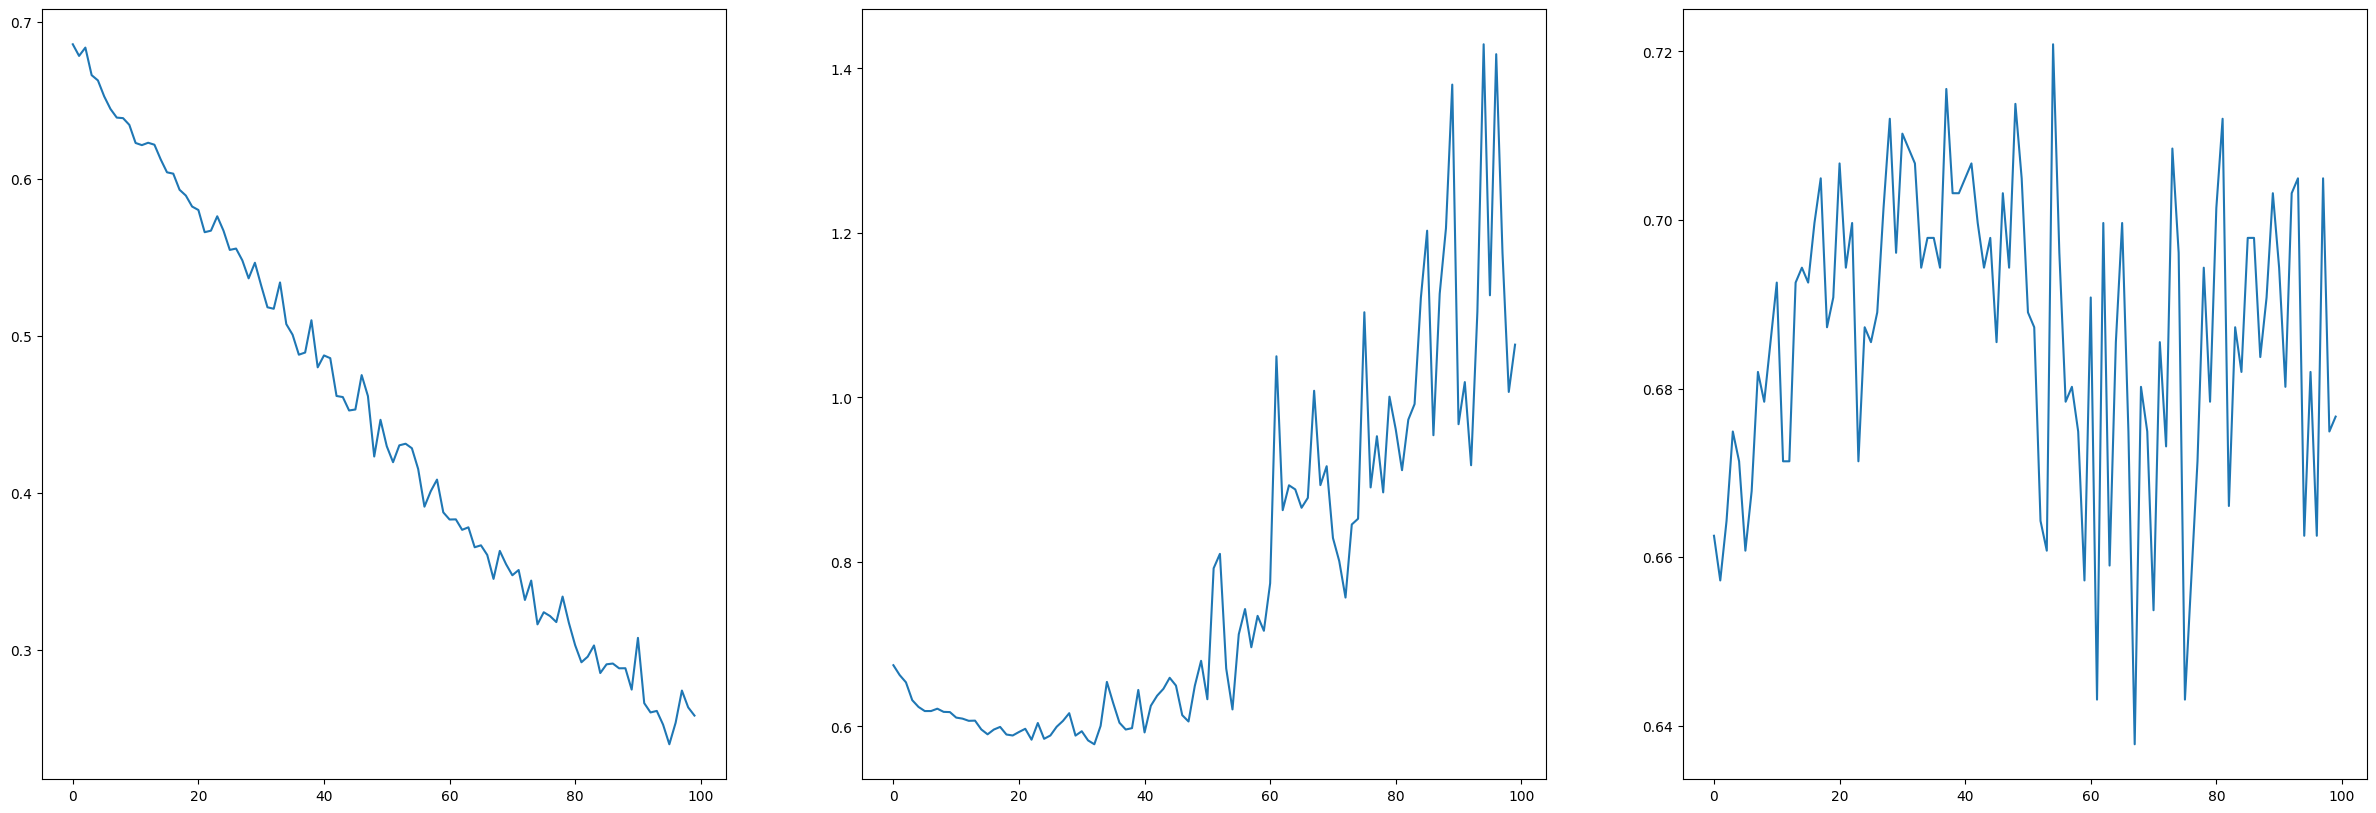

In [6]:
#load model with best performance
model.load_weights("/home/jj/FYP/Checkpoint/EfficientNet/dense_init_checkpoint/cp-0010.ckpt")
pre_trained.trainable = True
for layer in pre_trained.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
      layer.trainable = False
for layer in pre_trained.layers[:-75]:
  layer.trainable = False
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate = 5e-6),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.FalsePositives(),tf.keras.metrics.FalseNegatives()]
)
model.summary()
checkpoint_path = "/home/jj/FYP/Checkpoint/EfficientNet/fine_tuning_training_2_checkpoint/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')
total_epochs = 100
history_init = model.fit(train_ds_aug
                    ,epochs=total_epochs
                    # ,initial_epoch=38
                    ,validation_data=val_ds_aug
                    ,callbacks = [cp_callback]
                    )
# model.save(save_dir + "inceptionv3")
plt.figure(figsize=(30,10))
plt.subplot(131)
plt.plot(history_init.history['loss'])
plt.subplot(132)
plt.plot(history_init.history['val_loss'])
plt.subplot(133)
plt.plot(history_init.history['val_binary_accuracy'])